In [2]:
import os
import pandas as pd 
import numpy as np

from rdkit import Chem
from rdkit.Chem import Crippen
from mapchiral.mapchiral import encode

from umap import UMAP

from matplotlib.colors import ListedColormap, LogNorm 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Menlo"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 22})

#### Datasets

Read data

In [3]:
activity = pd.read_csv('data/activity_clean.csv')
hemolysis = pd.read_csv('data/hemolysis_clean.csv')

Merge data

In [4]:
merged = pd.merge(activity, hemolysis, on='sequence', how='left')
merged.rename(columns={'label_x':'activity', 'label_y':'hemolysis'}, inplace=True)
merged.fillna(-1, inplace=True)
merged.sort_values(by=['activity', 'hemolysis'], inplace=True)
merged = merged[['sequence', 'activity', 'hemolysis']].copy()

Calculate fingerprints and properties

In [5]:
def FracC(mol):
    smarts = Chem.MolFromSmarts('[C]')
    return len(mol.GetSubstructMatches(smarts, uniquify=True))/len(mol.GetAtoms())

merged['mol'] = merged['sequence'].apply(lambda x: Chem.MolFromSequence(x))
merged['hac'] = merged['mol'].apply(lambda x: x.GetNumHeavyAtoms())
merged['frac_c'] = merged['mol'].apply(FracC)
merged['fingerprint'] = merged['mol'].apply(lambda x: encode(x, max_radius=2, n_permutations=2048))

Calculate UMAP layout

In [6]:
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='jaccard', random_state=42)
embedding = umap.fit_transform(np.array(merged['fingerprint'].tolist()))

/home/markus/miniconda3/envs/openaienv/lib/python3.12/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/markus/miniconda3/envs/openaienv/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


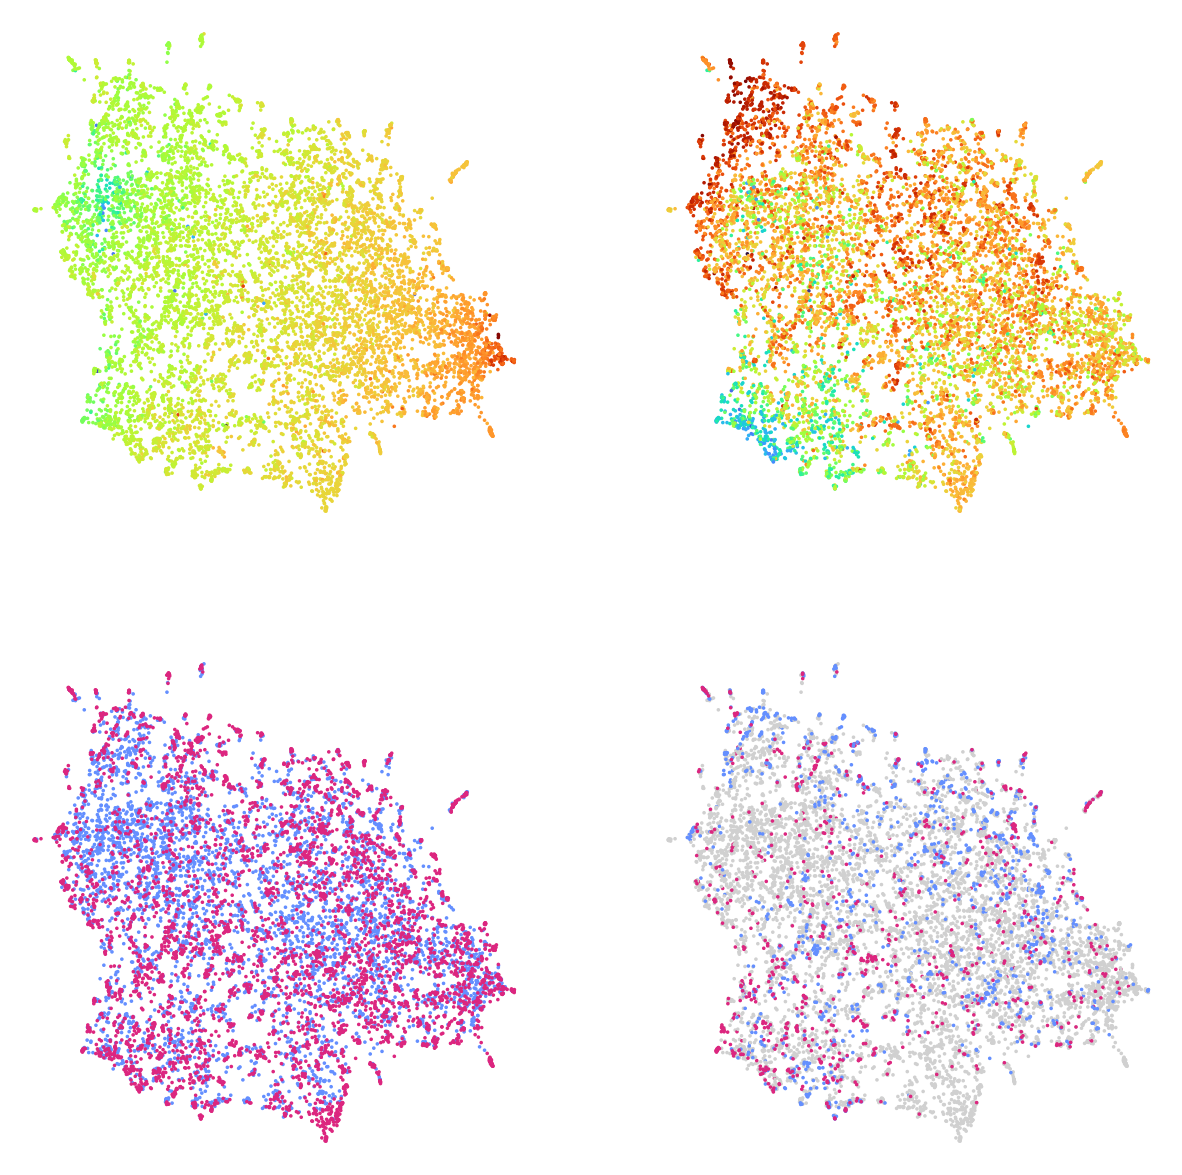

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

cmap2 = ListedColormap(['#648FFF', '#DC267F'])
cmap3 = ListedColormap(['#D0D0D0', '#648FFF', '#DC267F'])

scatter1 = ax1.scatter(embedding[:, 0], embedding[:, 1], c=merged['hac'], cmap='turbo', s=2.5, norm=LogNorm())
scatter2 = ax2.scatter(embedding[:, 0], embedding[:, 1], c=merged['frac_c'], cmap='turbo', s=2.5)
scatter3 = ax3.scatter(embedding[:, 0], embedding[:, 1], c=merged['activity'], cmap=cmap2, s=2.5)
scatter4 = ax4.scatter(embedding[:, 0], embedding[:, 1], c=merged['hemolysis'], cmap=cmap3, s=2.5)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.savefig('figures/UMAPs.png', dpi=1200, bbox_inches='tight')

#### Cross-Validations

Plot cross-validation results of the activity and hemolysis models

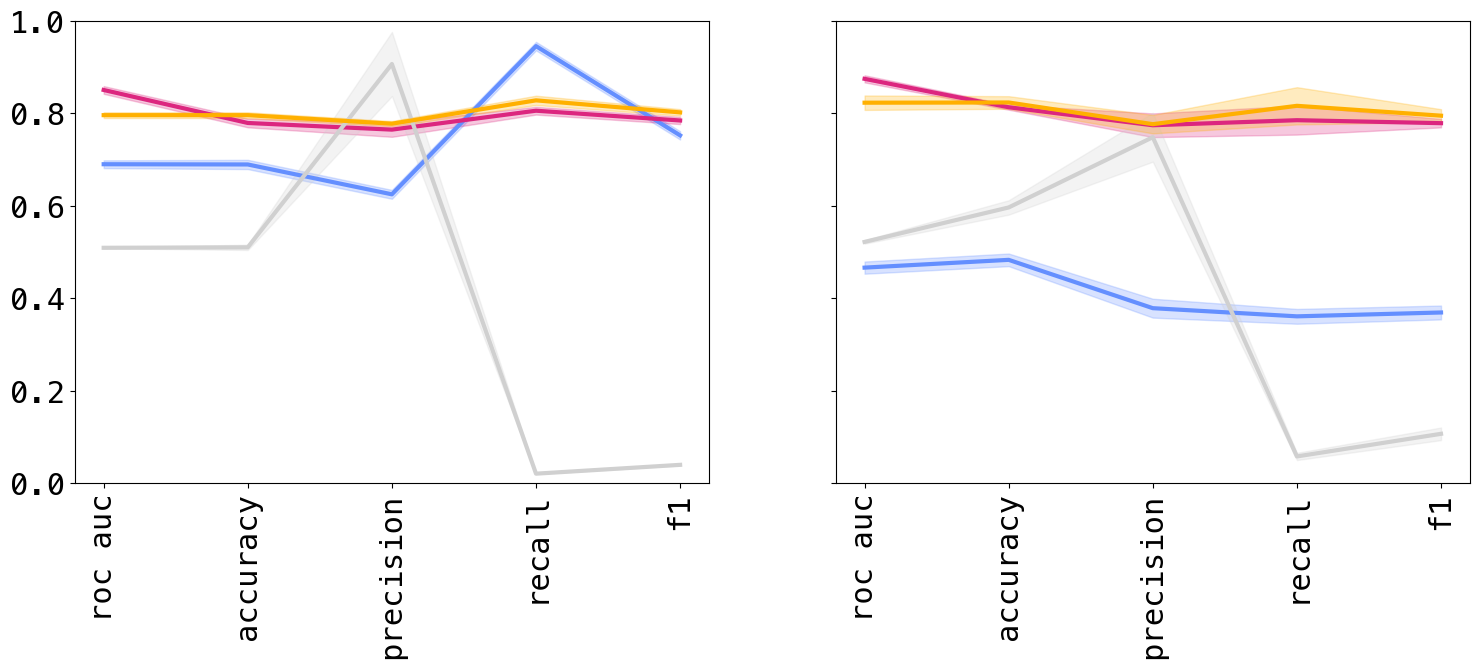

In [34]:
filenames = os.listdir('results/')
filenames.sort()

metrics = ['roc auc', 'accuracy', 'precision', 'recall', 'f1']
colors = ['#648FFF', '#648FFF', '#DC267F', '#DC267F', '#D0D0D0', '#FFB000', '#D0D0D0', '#FFB000']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

for file in filenames:

    df = pd.read_csv('results/' + file)

    model_name = ' '.join(file.split('_')[:-1])
    mean_values = df.iloc[-2, 1:].values.tolist()
    std_values = df.iloc[-1, 1:].values.tolist()

    if 'activity' in file:
        ax1.plot(mean_values, label=model_name, color=colors[filenames.index(file)], linewidth=3)
        ax1.fill_between(range(len(mean_values)), np.array(mean_values) - np.array(std_values), np.array(mean_values) + np.array(std_values), alpha=0.25, color=colors[filenames.index(file)])
    
    elif 'hemolysis' in file:
        ax2.plot(mean_values, label=model_name, color=colors[filenames.index(file)], linewidth=3)
        ax2.fill_between(range(len(mean_values)), np.array(mean_values) - np.array(std_values), np.array(mean_values) + np.array(std_values), alpha=0.25, color=colors[filenames.index(file)])

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)

ax1.set_xticks(range(len(metrics)))
ax2.set_xticks(range(len(metrics)))

ax1.set_xticklabels(metrics, rotation=90)
ax2.set_xticklabels(metrics, rotation=90)

plt.savefig('figures/metrics.png', dpi=1200, bbox_inches='tight')